# Some Insights 

Here we investigate a little bit mroe some of the timing concpets we use in the Stingray tutorial. 

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import black
# Uncomment and run this before releasing a new version of the docs
# import jupyter_black

# jupyter_black.load(
#     lab=False,
#     line_length=100,
#     verbosity="DEBUG",
#     target_version=black.TargetVersion.PY310,
# )

import copy
import glob
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

from astropy.table import Table
from astropy.modeling import models

from stingray.gti import create_gti_from_condition, gti_border_bins, time_intervals_from_gtis, cross_two_gtis
from stingray.utils import show_progress
from stingray.fourier import avg_cs_from_events, avg_pds_from_events, poisson_level, get_average_ctrate
from stingray import AveragedPowerspectrum, AveragedCrossspectrum, EventList
from stingray.modeling.parameterestimation import PSDLogLikelihood


## 1 - Why are gaps so annoying when doing timing? 


When we do timing, we use the **Fast Fourier Transform (FFTs)**, which assumes uniform, contiguous sampling. Having gaps in a time series equals putting zeros here and there, which equals multiplying the true signal _x(t)_ by a sampling/window function _w(t)_ that is 1 where you observed and 0 in the gaps. I.e.:

$x_{obs}(t) = x(t)w(t)$

which in frequency space is 

$X_{obs}(f) = 𝑋(f) * 𝑊(f)$

so the spectrum you measure is the true spectrum _convolved_ with the Fourier transform of your window function. Gaps in w(t) make W(f) full of side lobes. This generates a number of issues.

**Leakage & sidelobes** - The shape of the spectral window W(f) redistributes power from real features into nearby (and harmonically related) frequencies, creating false detections and masking weak signals. 

**Alias (especially bad if the gaps are regular)** -  any periodicity in the sampling shows up as a comb in 𝑊(f), so real peaked signals are then surrounded by _aliases_ at +/- the sampling frequency.

**Distorted noise statistics** - gaps changes the variance of the periodogram and induces correlation in the noise of different frequency bins. This implies that the simple $\chi^2$ statistics we rely on to measure the significance of power spectral features no longer holds.

**Reduced sensitivity & resolution**  - Gaps in the time series reduce the effective exposure, and the spectral window W(f) broadens the features, so that the noise floor raises, and the effective frequency resolution is less than than the nominal 1/T.

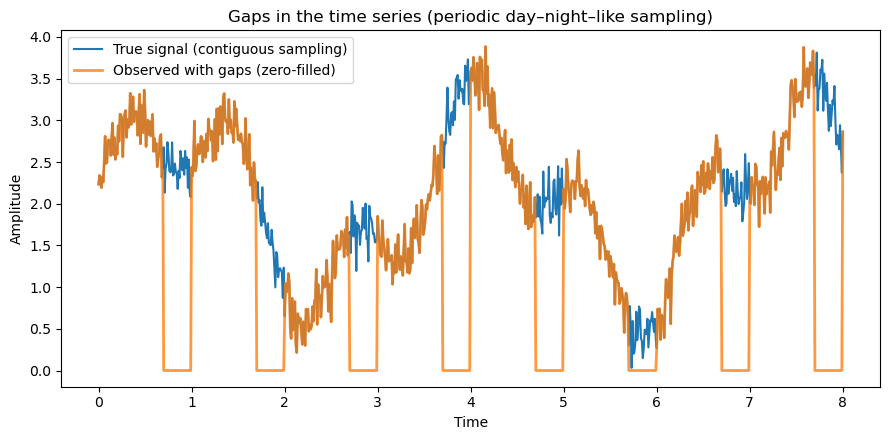

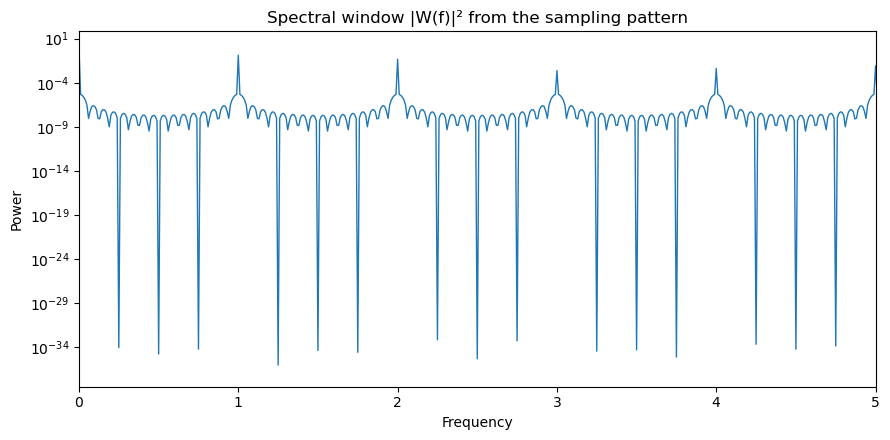

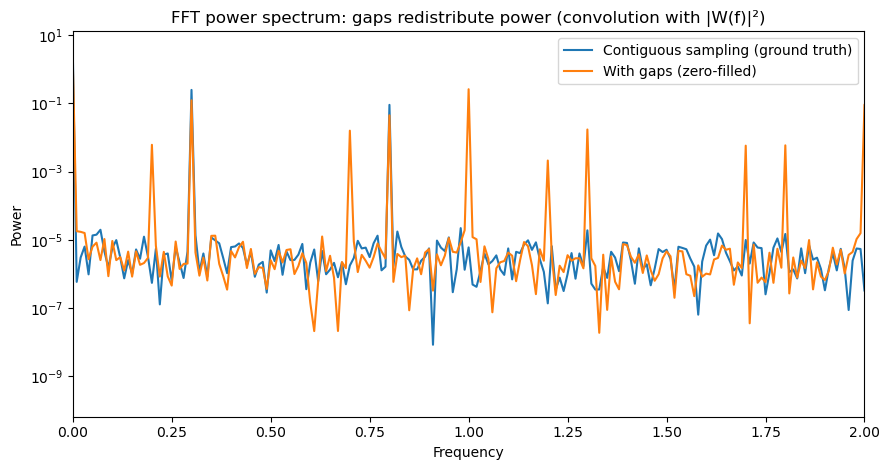

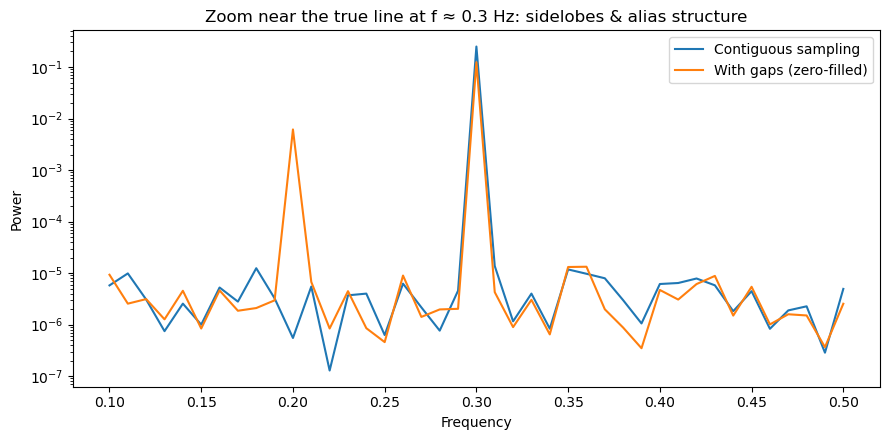

In [6]:
# Simulate a signal, introduce periodic gaps, and show how gaps distort the FFT

# Set random seed for reproducibility
rng = np.random.default_rng(7)

# Simulation parameters
T = 100.0                 # total duration (arbitrary units)
dt = 0.01                 # uniform sampling interval, or time resolution
t = np.arange(0, T, dt)   # time array
N = t.size                # number of samples
fs = 1.0 / dt             # sampling frequency

# True signal: two sinusoids + white noise
f1 = 0.30   # Hz
f2 = 0.80   # Hz
x_true = 2+(np.sin(2*np.pi*f1*t) +
          0.6*np.sin(2*np.pi*f2*t + 0.4) +
          0.2*rng.standard_normal(N))

# --------
# Option 1 - Create periodic gaps: observe only 70% of each "cycle" of length 1 unit
duty_cycle = 0.70
period = 1
mask = (t % period) < (duty_cycle * period)        # 1 where observed, 0 in gaps (periodic window)
w = mask.astype(float)

# Option 2 - Create  random gaps
#keep_prob = 0.96
#mask = rng.random(t.size) < keep_prob

## Optional: thicken the holes into short gaps
#from scipy.ndimage import binary_erosion
#mask = binary_erosion(mask, iterations=3)
#w = mask.astype(float)
# --------

# Zero-filled (naïve) series for FFT
x_zero = x_true * w

# --- Figure 1: Time series (clean vs gapped) ---
# Show a small time window to make gaps visible
view_start = 0
view_end = 8
sel = (t >= view_start) & (t <= view_end)

plt.figure(figsize=(9, 4.5))
plt.plot(t[sel], x_true[sel], label="True signal (contiguous sampling)")
plt.plot(t[sel], x_zero[sel], label="Observed with gaps (zero-filled)", linewidth=2, alpha=0.8)
plt.title("Gaps in the time series (periodic day–night–like sampling)")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
plt.tight_layout()
plt.show()

# --- Frequency axes for real FFTs ---
freqs = np.fft.rfftfreq(N, d=dt)

# --- Figure 2: Spectral window |W(f)| from the sampling mask ---
# (Shows comb structure and sidelobes that will convolve with the true spectrum)
W = np.fft.rfft(w) / w.sum()  # normalize by total observed samples
W_power = np.abs(W)**2

plt.figure(figsize=(9, 4.5))
plt.semilogy(freqs, W_power, linewidth=1)
plt.title("Spectral window |W(f)|² from the sampling pattern")
plt.xlabel("Frequency")
plt.ylabel("Power")
plt.xlim(0, 5)   # show the low-frequency region where aliases are most visible
plt.tight_layout()
plt.show()

# --- Figure 3: FFT power spectra (clean vs gapped/zero-filled) ---
X_true = np.fft.rfft(x_true) / N
X_zero = np.fft.rfft(x_zero) / N
P_true = np.abs(X_true)**2
P_zero = np.abs(X_zero)**2

plt.figure(figsize=(9, 4.8))
plt.semilogy(freqs, P_true, label="Contiguous sampling (ground truth)")
plt.semilogy(freqs, P_zero, label="With gaps (zero-filled)")
plt.title("FFT power spectrum: gaps redistribute power (convolution with |W(f)|²)")
plt.xlabel("Frequency")
plt.ylabel("Power")
plt.xlim(0, 2.0)
plt.legend()
plt.tight_layout()
plt.show()

# --- Optional: zoom around f1 to highlight leakage and aliases ---
zoom_width = 0.2
center = f1
zoom_sel = (freqs >= center - zoom_width) & (freqs <= center + zoom_width)

plt.figure(figsize=(9, 4.5))
plt.semilogy(freqs[zoom_sel], P_true[zoom_sel], label="Contiguous sampling")
plt.semilogy(freqs[zoom_sel], P_zero[zoom_sel], label="With gaps (zero-filled)")
plt.title(f"Zoom near the true line at f ≈ {f1} Hz: sidelobes & alias structure")
plt.xlabel("Frequency")
plt.ylabel("Power")
plt.legend()
plt.tight_layout()
plt.show()


**>YOUR TURN 1-i: (a) change duty cycle and gaps period.** 
How does the window changes? What is the effect on the power spectrum? when are the effects worse? **(b) define radonm gaps and observe what changes**

---

## 2 - Bartlett's method

**Bartlett’s method** is a common method in X-ray timing, based on the averaging of periodograms from the same time-series, aimed at reducing the PDS variance.

This is what the method prescribes:

- Take your light curve and split it into M equal segments of length L. Discard the last one if its length is shorter than L.
- Compute a periodogram for each segment (Leahy, rms or any other normalization).
- Average the M periodograms frequency-by-frequency.

This way the **time resolution remains unchanged**, **the frequency resolution is set by the segment length L** and equals 1/(2L) is L is in seconds (hence it is much lower than what you would obtain considering the entire lightcurve at once), but **the statistical scatter in the PDS drops by approximately $\sqrt(M)$**.

For clarity, the following code unpacks explicitly what Stingray does in just one line, i.e.: 

_pds = AveragedPowerspectrum.from_events(
    events, segment_size=segment_size, dt=dt, norm=norm, use_common_mean=True)_


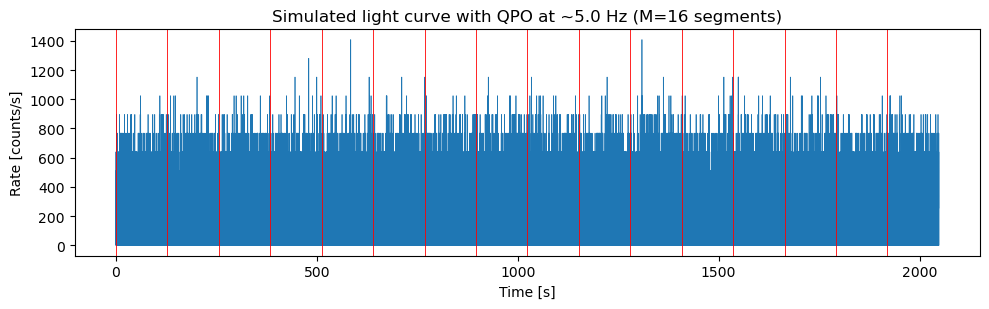

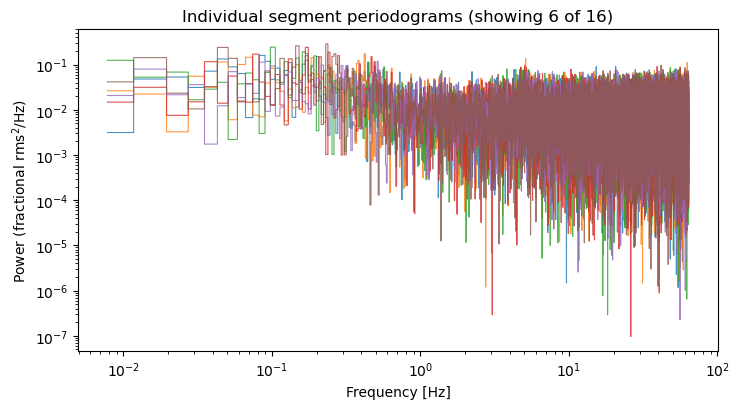

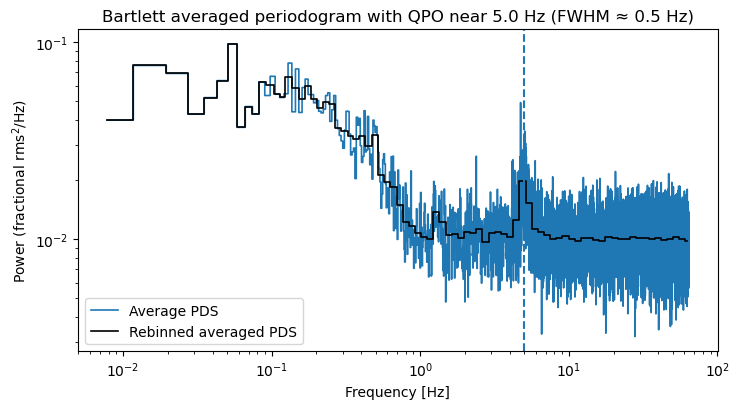

In [10]:
# Simulate a light curve, split into segments, 
# compute periodograms for each segment, and then average them.

import numpy as np
import matplotlib.pyplot as plt

# -------------------- Light curve Simulation --------------------
rng = np.random.default_rng(7)

# Time grid
dt = 1/128.0             # 128 Hz sampling         - THIS IS THE TIME RESOLUTION 
t_total = 2048.0         # in seconds              - THIS IS THE TOTAL LENGTHS OF THE LIGHTCURVE or TIME SERIES
t = np.arange(0, t_total, dt)
n = t.size

rate_mean = 200.0       # counts/s (mean source rate)

# QPO parameters
f0 = 5.0               # Hz (central frequency)
fwhm = 0.5             # Hz (QPO width)
frac_rms_qpo = 0.10    # target fractional rms of the QPO (10%)

# optional weak broadband noise
broadband_frac_rms = 0.15

# -------------------- Sample from Lorentzian --------------------
def sample_lorentzian(center, fwhm, size, fmin=0.0, fmax=np.inf, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    gamma = fwhm/2.0
    freqs = center + gamma * np.tan(np.pi * (rng.random(size) - 0.5))
    mask = (freqs >= fmin) & (freqs <= fmax)
    while not np.all(mask):
        k = np.sum(~mask)
        new = center + gamma * np.tan(np.pi * (rng.random(k) - 0.5))
        freqs[~mask] = new
        mask = (freqs >= fmin) & (freqs <= fmax)
    return freqs

# -------------------- Build QPO time series --------------------
# This is a way (there are many) to simulate a QPO to add to your time series. 
K = 200                              # number of sinusoids to approximate QPO
freqs = sample_lorentzian(f0, fwhm, K, fmin=1/t_total, fmax=1/(2*dt), rng=rng)
phases = rng.uniform(0, 2*np.pi, size=K)

# Set amplitudes so that total fractional rms equals frac_rms_qpo
a = rate_mean * frac_rms_qpo * np.sqrt(2.0 / K)
qpo = np.sum([a * np.sin(2*np.pi*freqs[i]*t + phases[i]) for i in range(K)], axis=0)

# optional weak broadband noise
broad = rng.normal(0.0, 1.0, size=n)
broad = np.convolve(broad, np.ones(129)/129, mode='same')
if np.std(broad) > 0:
    broad = broad / np.std(broad)
broad *= rate_mean * broadband_frac_rms

# instantaneous rate (non-negative)
rate = np.clip(rate_mean + qpo + broad, a_min=0, a_max=None)
lam = rate * dt
counts = rng.poisson(lam)
rate_series = counts / dt

# -------------------- Segmenting for Bartlett --------------------
seglen = 128              # -- THIS IS THE LENGHTS OF EACH SEGMENT
nseg = int(seglen / dt)   # -- Discard incomplete segments
M = n // nseg
N_use = M * nseg
t_use = t[:N_use]
x = rate_series[:N_use]

seg_edges = np.arange(0, N_use + 1, nseg)

# -------------------- Periodogram helper (fractional rms^2/Hz) --------------------
def one_sided_periodogram(xseg, dt):
    x0 = xseg - np.mean(xseg)
    X = np.fft.rfft(x0)
    freqs = np.fft.rfftfreq(x0.size, dt)
    P = (2.0 * dt / x0.size) * (np.abs(X) ** 2)
    mu = np.mean(xseg)
    if mu > 0:
        P = P / (mu**2)
    return freqs, P

# Compute all segment periodograms
all_freqs = None
all_P = []
for k in range(M):
    seg = x[k*nseg:(k+1)*nseg]
    f, P = one_sided_periodogram(seg, dt)
    if all_freqs is None:
        all_freqs = f
    all_P.append(P)
all_P = np.array(all_P)
P_avg = np.mean(all_P, axis=0)


# -------------------- Geometric rebinning helper --------------------
def geometric_rebin(freq, power, factor=1.1, fmin=None, fmax=None, min_count=1):
    """
    Geometric (log) rebin of a 1-sided periodogram by averaging powers in
    bins whose edges grow by 'factor' each step.
      - factor=1.1 -> ~10% wider bins; smaller => finer
      - min_count: minimum # of points required per bin
    Returns: (f_reb, P_reb)
    """
    f = np.asarray(freq)
    P = np.asarray(power)
    if fmin is None:
        fmin = f[f > 0][0]           # skip DC bin
    if fmax is None:
        fmax = f[-1]

    # build geometric bin edges
    edges = [fmin]
    while edges[-1] < fmax:
        edges.append(edges[-1] * factor)
    edges = np.array(edges)

    # digitize and average within bins
    idx = np.digitize(f, edges)
    f_out, P_out = [], []
    for b in range(1, len(edges)):
        sel = idx == b
        if sel.sum() >= min_count:
            # geometric-mean freq for the bin center; arithmetic mean power
            f_out.append(np.exp(np.mean(np.log(f[sel]))))
            P_out.append(P[sel].mean())
    return np.array(f_out), np.array(P_out)

# Rebin the averaged PDS (skip DC bin)
f_geo, P_geo = geometric_rebin(all_freqs[1:], P_avg[1:], factor=1.1)


# -------------------- Figure A: Light curve with segments --------------------
plt.figure(figsize=(10, 3.2))
plt.plot(t_use, x, lw=0.5)
for edge in t_use[seg_edges[:-1]]:
    plt.axvline(edge, ls='-', lw=0.6, alpha=1, color='red')
plt.xlabel("Time [s]")
plt.ylabel("Rate [counts/s]")
plt.title(f"Simulated light curve with QPO at ~{f0} Hz (M={M} segments)")
plt.tight_layout()
plt.show()

# -------------------- Figure B: First few segment periodograms --------------------
K_show = min(6, M)
plt.figure(figsize=(7.5, 4.2))
for k in range(K_show):
    plt.loglog(all_freqs[1:], all_P[k,1:], lw=0.8, alpha=0.8,drawstyle="steps-mid")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Power (fractional rms$^2$/Hz)")
plt.title(f"Individual segment periodograms (showing {K_show} of {M})")
plt.tight_layout()
plt.show()

# -------------------- Figure C: Bartlett averaged periodogram --------------------
plt.figure(figsize=(7.5, 4.2))
#for k in range(K_show):
#    plt.loglog(all_freqs[1:], all_P[k,1:], lw=0.8, alpha=0.8,drawstyle="steps-mid")

plt.loglog(all_freqs[1:], P_avg[1:], drawstyle='steps-mid', lw=1.2, label="Average PDS")
plt.loglog(f_geo, P_geo, drawstyle='steps-mid', lw=1.2, color='black', label="Rebinned averaged PDS")
plt.legend()
plt.axvline(f0, ls='--')
plt.xlabel("Frequency [Hz]")
plt.ylabel("Power (fractional rms$^2$/Hz)")
plt.title(f"Bartlett averaged periodogram with QPO near {f0} Hz (FWHM ≈ {fwhm} Hz)")
plt.tight_layout()
plt.show()


**> YOUR TURN 2-i: change the Bartlett's parameters.** 
Change the number of segments (i.e. their lengths). How does the average PDS changes? how many intervals you need to significanlty improve the quality of the average PDS with respect to the PDS from the entire dataset? 

---

# 3 - About Power spectra and Cross spectra

Let x(t) and y(t) be mean-subtracted time series, and X(f), Y(f) their discrete Fourier transforms over segments of length T. 

The **Cross spectrum**  is defined as:

$ G_{xy}(f) \equiv X^{\ast}(f)\,Y(f)$
    
and encodes **amplitude correlation** (magnitude) and **phase lag** (argument) between \(x\) and \(y\) at each frequency.

The **Power spectrum** (or **auto spectrum**) is defined as:

$  G_{xx}(f) \equiv X^{\ast}(f)\,X(f) = |X(f)|^2 $

And similarly, $G_{yy}(f)=|Y(f)|^2 $ for y. 

- **Power spectrum G$_{xx}$**: it gives the distribution of a single signal’s variance over frequency (noise continuum, QPOs, breaks). It is **real and non-negative** and contains **no phase info**.

- **Cross spectrum G$_{xy}$**: It gives the relationship of variability between two signals, and contains both a real and a complex part. 
  - Magnitude $|G_{xy}(f)|$: strength of correlated variability at \(f\).
  - Phase $\phi_{xy}(f)=\arg G_{xy}(f)$: **phase lag**; time lag \(\tau(f)=\phi_{xy}(f)/(2\pi f)\).
  
From the Cross spectrum you derive the **Coherence** (fraction of power linearly shared):

$$    \gamma^2(f)=\frac{|\langle X^{\ast}Y\rangle|^2}{\langle |X|^2\rangle\,\langle |Y|^2\rangle}\in[0,1]$$

which is the fraction of power in x that linearly predicts y at frequency f.

## Practical differences

**Single-band vs. inter-band:** power spectra quantify power in one band; cross spectra quantify coupling between bands (e.g., soft ↔ hard X-ray variability).

**Real vs. complex:** the power spectrum is scalar, the cross is complex → you get phase/time lags and coherence in addition to correlated power.

**Noise bias:** Poisson noise adds a positive bias to auto-power that must be subtracted; the mean cross spectrum is unbiased by independent noise between bands (although it increases the variance), which is why cross-spectral lags can be robust at high frequencies where auto spectra are noise-dominated at ghigh frequencies.

**Interpretation:** The power-spectrum answers the question “what frequencies are present?”; the cross spectrum  answers the question “which frequencies are shared, with what lag and linearity?”

---

## 4 - Why do we use Lorentizains to model PDS?

There is no strictly physically motivated answer to this question. The short anwer to this quesrtion is: because they work very well. Specifically: 

(i) **Lorentzians match observed shape of a typical PDS:** PDS from X-ray binaries are a mix of band-limited noise, i.e. broad humps with smooth low/high-frequency roll-offs, covering large frequency ranges, and Quasi Periodic Oscillations (QPOs), i.e. relatively narrow peaks with a clear centroid frequency. A Lorentzian shape can easily fit either a broad-band component, or a QPO. Sums of a few Lorentzians are able to well-describe a large variaty of PDS from X-ray binaries in different accretion states.
 
(ii) **Lorentzians are simple functions, with a few easily interpretable parameters**: A Lorentzian is defined as
    
$$ L(\nu)=\frac{A\,\Delta}{\pi\big[(\nu-\nu_0)^2+\Delta^2\big]} $$

where:

- **$\nu_{0}$** is the centroid (oscillation frequency, the centroid in the case of a QPO)  
- **$\Delta$** is the Half Width at Half Maximum.
- **A** is the amplitude.
      
Based on these parameters, we can define two important quantities:

- **Quality factor:**     $Q=\nu_0/(2\Delta)$ , which gives the coherence of a signal, relevant in particular for QPOs.
- **Characteristic frequency:** $\nu_{\max}=\sqrt{\nu_0^2+\Delta^2}$, i.e. the frequency where most of the power is sitting. Very similar to $\nu_0$ for narrow components, increasingly different (and higher than $\nu_0$) for broad components.

(iii) **Lorentzians are statistically well-behaved:** When we use the Bartlett method for averaging, PSD powers are $\chi^2$-distributed. Lorentzians are smooth, positive-definite, and add linearly, so fits are stable and uncertainty propagation is straightforward.

(iv) **Lorentzians are Physically plausible**: Lorentzians are the Fourier signatures of damped, stochastic oscillators and of many linear, causal processes. For example a **damped harmonic oscillator (stochastically driven)** is well modelles in Forier space by a Lorentzian centered at a given frequency (i.e., a QPO).

The accretion flow around an accreting black hole or neutron star likely hosts such processes across differernt radii and timescales.


## How do they compare with other shapes?

In the past PDS were fitted with a combinationf powerlaws or broken-powerlaw, and Gaussian shapes. While the powerlaws might have been good approximations of the broad-band noise components, Gaussians have wings that decay too fast. Observed PSD features, instead, often show tails consistent with damping effects, which are better modelled with Lorentzians. 


$$ \mathcal{L}_\mathrm{avg}(\theta) = -2ML \sum_{j=1}^{N/2} \left\{\frac{P_j}{S_j(\theta)} + \ln{S_j(\theta) + \left( \frac{1}{ML} - 1 \right)\ln{P_j} + c(2ML) }\right\} $$

---

# 5 - Time Lags vs. Phase Lags (and how to convert)

## Definitions

- The **Phase lags** $\phi(f)$ are the argument (angle) of the complex **cross spectrum** between two signals at Fourier frequency \(f\). They are expressed in units of **radians**, and are often wrapped to (-$\pi$,$\pi$]), or (less often) in **degrees** (remember $\phi_{\deg} = \phi_{\text{rad}} \times \frac{180}{\pi}$).

- The **Time lags** \(\tau(f)\) are the actual **time delay** between the signals at frequency \(f\). They are expressed in units of **seconds**.


## Conversion

Phase and time lags are related by a simple frequency-dependent conversion:


$$\phi(f) = \pm\,2\pi f\,\tau(f)$$

$$\tau(f) = \pm\,\frac{\phi(f)}{2\pi f} $$


The **sign** depends on your cross-spectrum convention. 


- If $(C_{xy}(f)=X^{\ast}(f)\,Y(f)$ and \(y\) **lags** \(x\) by $\tau>0$, then

  
  $$  \phi(f) = -\,2\pi f\,\tau(f) \quad\Rightarrow\quad $$
  $$ \tau(f) = -\,\frac{\phi(f)}{2\pi f}$$
  
- If you instead use $C_{yx}(f)=Y^{\ast}(f)\,X(f)$, the sign flips:
  
  $$\tau(f) = +\,\frac{\phi(f)}{2\pi f}$$

One can easily verify what convention a given software uses with a synthetic test, i.e. shift one series by a known $\tau$. 

